In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     BatchNormalization, GlobalAveragePooling2D, Input)
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,
                                        Callback)
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             cohen_kappa_score, accuracy_score, precision_recall_fscore_support)
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.metrics import Precision, Recall, AUC
import warnings
import logging

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')
# Set TensorFlow logging level to suppress unnecessary messages
tf.get_logger().setLevel(logging.ERROR)

In [3]:
# --- Configuration ---
DATA_DIR = r'/content/drive/MyDrive/Datasets/Chest CT-Scan images Dataset' # Change if needed
IMG_HEIGHT, IMG_WIDTH = 224, 224  # Target image dimensions (standard for many pre-trained models)
BATCH_SIZE = 16                   # Number of samples per gradient update
SEED = 42                         # Random seed for reproducibility
VAL_SPLIT = 0.20                  # Proportion of data for validation (used for simple split)
N_SPLITS_KFOLD = 5                # Number of folds for K-Fold Cross-Validation

# Training parameters (can be adjusted)
INITIAL_EPOCHS = 50              # Max epochs for initial transfer learning phase
FINETUNE_EPOCHS = 30             # Max epochs for fine-tuning phase
CNN_EPOCHS = 75                  # Max epochs for custom CNN training

INITIAL_LR = 1e-3                 # Initial learning rate for transfer learning
FINETUNE_LR = 1e-5                # Learning rate for fine-tuning
CNN_LR = 1e-4                     # Learning rate for custom CNN

# Callbacks configuration
EARLY_STOPPING_PATIENCE = 10      # Stop training if no improvement after this many epochs
REDUCE_LR_PATIENCE = 5            # Reduce LR if no improvement after this many epochs
REDUCE_LR_FACTOR = 0.2            # Factor by which to reduce LR

# Model checkpoint paths
CNN_MODEL_PATH = '/content/drive/MyDrive/ctmodels/best_cnn_model.keras'
MOBILENET_MODEL_PATH = '/content/drive/MyDrive/ctmodels/best_mobilenet_model.keras'
RESNET_MODEL_PATH = '/content/drive/MyDrive/ctmodels/best_resnet_model.keras'
KFOLD_MODEL_PATH_TEMPLATE = '/content/drive/MyDrive/ctmodels/best_resnet_kfold_split_{split}.keras'

# Set random seeds for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

if not os.path.exists(DATA_DIR):
    print(f"Error: Data directory not found at {DATA_DIR}")
else:
    print(f"Data directory found: {DATA_DIR}")

Data directory found: /content/drive/MyDrive/Datasets/Chest CT-Scan images Dataset


In [4]:
classes = sorted([cls for cls in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, cls))])
print("\nClasses found:", classes)
num_classes = len(classes)


Classes found: ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']



Image counts per class:
- adenocarcinoma: 338 images
- large.cell.carcinoma: 187 images
- normal: 215 images
- squamous.cell.carcinoma: 260 images

Total images found: 1000


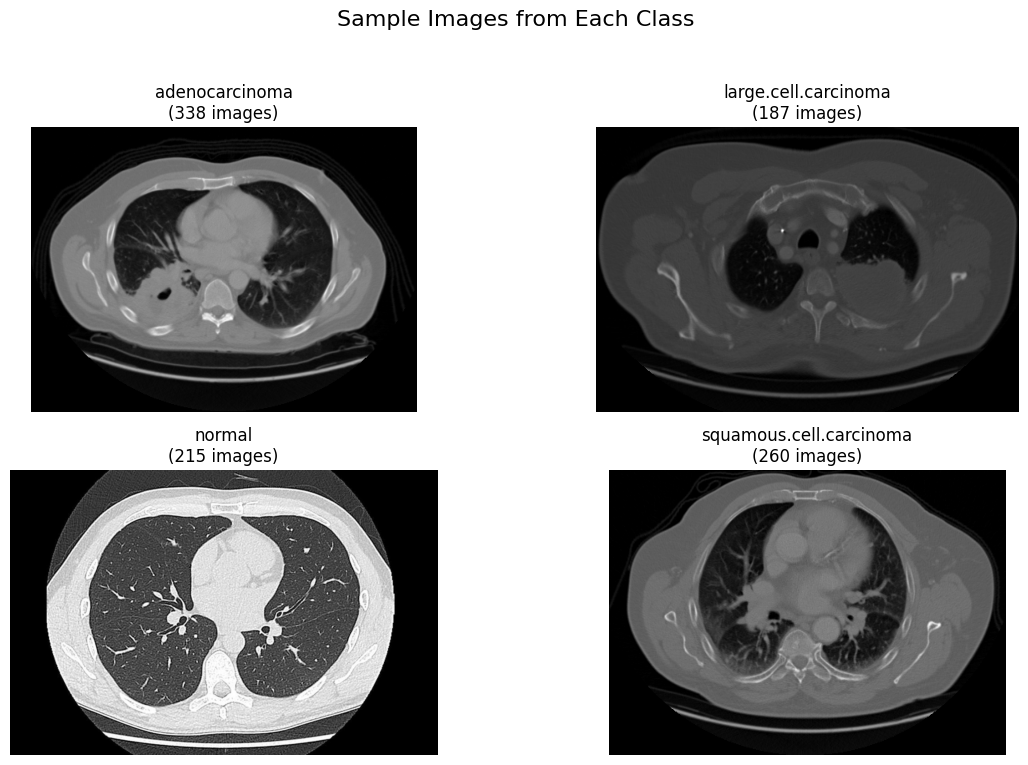

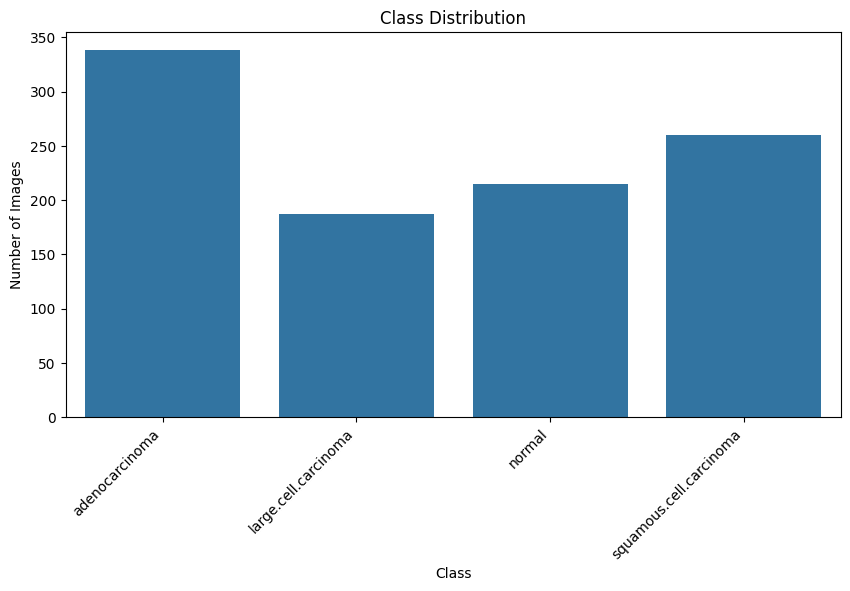

In [5]:
if num_classes == 0:
    print("Error: No classes found in the dataset directory.")
else:
    # Store image counts per class
    class_counts = {}
    all_filepaths = []
    all_labels = []

    print("\nImage counts per class:")
    for i, cls in enumerate(classes):
        cls_path = os.path.join(DATA_DIR, cls)
        images = [img for img in os.listdir(cls_path) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
        count = len(images)
        class_counts[cls] = count
        print(f"- {cls}: {count} images")
        # Store filepaths and labels for potential later use (e.g., KFold)
        for img_name in images:
            all_filepaths.append(os.path.join(cls_path, img_name))
            all_labels.append(cls) # Store class name as label

    # Create a DataFrame for easier handling (especially for KFold)
    df = pd.DataFrame({'filepath': all_filepaths, 'label': all_labels})
    print(f"\nTotal images found: {len(df)}")

    # --- Visualize Sample Images ---
    num_rows = (num_classes + 1) // 2
    plt.figure(figsize=(12, 4 * num_rows))
    plt.suptitle("Sample Images from Each Class", fontsize=16)

    for i, cls in enumerate(classes):
        plt.subplot(num_rows, 2, i + 1)
        # Find a valid image path for the current class
        first_image_path = df[df['label'] == cls]['filepath'].iloc[0]
        try:
            img = cv2.imread(first_image_path)
            if img is None:
                print(f"Warning: Failed to load sample image: {first_image_path}")
                plt.title(f"{cls}\n(Image Load Error)")
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
                plt.imshow(img)
                plt.title(f"{cls}\n({class_counts[cls]} images)")
        except Exception as e:
            print(f"Error loading image {first_image_path}: {e}")
            plt.title(f"{cls}\n(Error: {e})")

        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

    # --- Visualize Class Distribution ---
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45, ha='right')
    plt.show()

    # Check for significant imbalance
    min_count = min(class_counts.values())
    max_count = max(class_counts.values())
    if max_count / min_count > 3: # Arbitrary threshold for imbalance warning
        print("\nWarning: Potential class imbalance detected.")


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    rotation_range=20,        # Increased rotation range
    width_shift_range=0.15,   # Increased horizontal shift
    height_shift_range=0.15,  # Increased vertical shift
    shear_range=0.15,         # Increased shear intensity
    zoom_range=0.15,          # Increased zoom range
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest',      # Strategy for filling pixels after transformations
    validation_split=VAL_SPLIT  # Reserve part of the data for validation
)

# Validation data should only be rescaled (no augmentation)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT # Must specify split again for the validation generator
)


In [7]:
# Create Training Generator
print("\nCreating Training Generator:")
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',   # For multi-class classification
    subset='training',          # Specify this is the training set
    seed=SEED,
    shuffle=True
)

# Create Validation Generator
print("\nCreating Validation Generator:")
validation_generator = validation_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',        # Specify this is the validation set
    seed=SEED,
    shuffle=False
)

# Verify class indices
print("\nClass Indices (should be consistent):")
print("Training Generator:", train_generator.class_indices)
print("Validation Generator:", validation_generator.class_indices)
class_indices = train_generator.class_indices


Creating Training Generator:
Found 801 images belonging to 4 classes.

Creating Validation Generator:
Found 199 images belonging to 4 classes.

Class Indices (should be consistent):
Training Generator: {'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'squamous.cell.carcinoma': 3}
Validation Generator: {'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'squamous.cell.carcinoma': 3}


In [8]:
# Calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE
if train_generator.samples % BATCH_SIZE != 0:
    steps_per_epoch += 1
if validation_generator.samples % BATCH_SIZE != 0:
    validation_steps += 1

print(f"\nTraining steps per epoch: {steps_per_epoch}")
print(f"Validation steps per epoch: {validation_steps}")


Training steps per epoch: 51
Validation steps per epoch: 13


In [9]:
#  Model Definitions

def build_custom_cnn(input_shape, num_classes, learning_rate=CNN_LR):
    """Builds a custom CNN model."""
    model = Sequential([
        # Input Layer
        Input(shape=input_shape),

        # Block 1
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.25),

        # Block 2
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.25),

        # Block 3
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.25),

        # Fully Connected Layers
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'), # Increased dense layer size
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Output layer
    ], name="Custom_CNN")

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print("Custom CNN Model Built and Compiled.")
    model.summary()
    return model

In [10]:
def build_transfer_model(base_model_fn, input_shape, num_classes, trainable_base=False, learning_rate=INITIAL_LR, model_name="Transfer_Model"):
    """Builds a transfer learning model with a specified base."""
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = trainable_base # Control freezing/unfreezing

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=trainable_base) # Use training=False if base is frozen
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x) # Slightly increased dropout
    x = Dense(256, activation='relu')(x) # Add an intermediate dense layer
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs, name=model_name)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(f"{model_name} Model Built and Compiled (Base Trainable: {trainable_base}).")
    model.summary()
    return model

In [11]:
#Training and Evaluation Utilities

# --- Callbacks ---
def get_callbacks(model_path, early_stopping_patience=EARLY_STOPPING_PATIENCE, reduce_lr_patience=REDUCE_LR_PATIENCE, reduce_lr_factor=REDUCE_LR_FACTOR, monitor='val_loss'):
    """Creates a list of standard callbacks."""
    early_stopping = EarlyStopping(
        monitor=monitor,
        patience=early_stopping_patience,
        restore_best_weights=True,
        verbose=1
    )
    model_checkpoint = ModelCheckpoint(
        filepath=model_path,
        monitor=monitor,
        save_best_only=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor=monitor,
        factor=reduce_lr_factor,
        patience=reduce_lr_patience,
        min_lr=1e-6, # Prevent LR from becoming too small
        verbose=1
    )
    return [early_stopping, model_checkpoint, reduce_lr]

# --- Plotting History ---
def plot_training_history(history, title_prefix=""):
    """Plots accuracy and loss curves from Keras history object."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title_prefix}Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title_prefix}Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

# --- Comprehensive Evaluation ---
def evaluate_model(model, generator, class_names):
    """Evaluates the model and returns comprehensive metrics."""
    print(f"\n--- Evaluating Model: {model.name} ---")
    generator.reset() # Ensure generator starts from the beginning

    # Predict probabilities
    y_pred_probs = model.predict(generator, steps=validation_steps, verbose=1)
    # Get predicted classes (indices)
    y_pred = np.argmax(y_pred_probs, axis=1)
    # Get true classes (indices)
    y_true = generator.classes[:len(y_pred)] # Ensure lengths match if generator doesn't perfectly divide

    if len(y_true) != len(y_pred):
         print(f"Warning: Mismatch in number of true labels ({len(y_true)}) and predictions ({len(y_pred)}). Adjusting...")
         min_len = min(len(y_true), len(y_pred))
         y_true = y_true[:min_len]
         y_pred = y_pred[:min_len]
         y_pred_probs = y_pred_probs[:min_len]


    # Calculate Metrics
    accuracy = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    # Classification Report (precision, recall, f1-score)
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    report_str = classification_report(y_true, y_pred, target_names=class_names)

    # ROC-AUC Score (One-vs-Rest for multiclass)
    try:
        y_true_one_hot = to_categorical(y_true, num_classes=len(class_names))
        roc_auc = roc_auc_score(y_true_one_hot, y_pred_probs, multi_class='ovr', average='macro')
    except ValueError as e:
        print(f"Warning: Could not calculate ROC-AUC. Error: {e}. Setting ROC-AUC to NaN.")
        # This might happen if a class is missing in the validation subset predictions
        roc_auc = np.nan


    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Print Metrics
    print(f"\nValidation Accuracy: {accuracy:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Macro Avg ROC-AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(report_str)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {model.name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Store results
    results = {
        'model_name': model.name,
        'accuracy': accuracy,
        'kappa': kappa,
        'roc_auc': roc_auc,
        'classification_report_dict': report_dict,
        'classification_report_str': report_str,
        'confusion_matrix': conf_matrix
    }
    return results

# Dictionary to store results from all models
all_model_results = {}

# Custom CNN


===== Training Custom CNN =====
Custom CNN Model Built and Compiled.


Model: "Custom_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 112, 112, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 56, 56, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 28, 28, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,02

 Total params: 323,876 (1.24 MB)

 Trainable params: 322,468 (1.23 MB)

 Non-trainable params: 1,408 (5.50 KB)


Starting Custom CNN Training...
Epoch 1/75
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3350 - loss: 1.9936
Epoch 1: val_accuracy improved from -inf to 0.26131, saving model to /content/drive/MyDrive/ctmodels/best_cnn_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 217s 4s/step - accuracy: 0.3358 - loss: 1.9900 - val_accuracy: 0.2613 - val_loss: 1.4069 - learning_rate: 1.0000e-04
Epoch 2/75
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.4579 - loss: 1.5392
Epoch 2: val_accuracy did not improve from 0.26131
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 264ms/step - accuracy: 0.4574 - loss: 1.5413 - val_accuracy: 0.2462 - val_loss: 1.5914 - learning_rate: 1.0000e-04
Epoch 3/75
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.4325 - loss: 1.5875
Epoch 3: val_accuracy did not improve from 0.26131
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 264ms/step - accuracy: 0.4323 - loss: 1.5875 - val_accuracy: 0.2362 - val_loss: 1.7109 - learning_rate: 1.0000e-04
Epoch 4/75
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step 

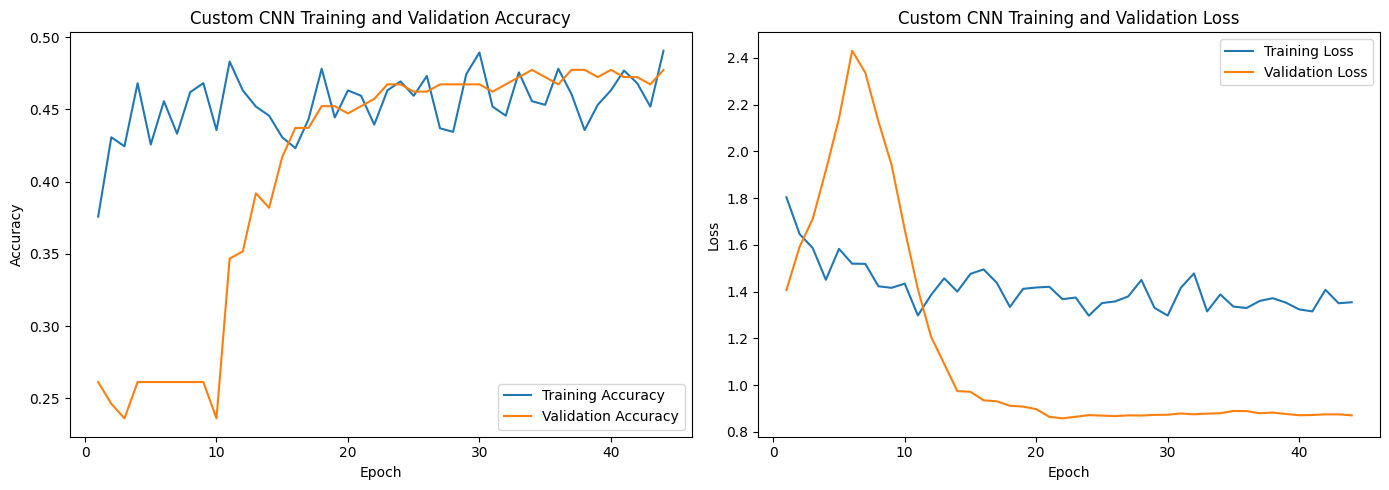


Loading best weights for Custom CNN...

--- Evaluating Model: Custom_CNN ---
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step

Validation Accuracy: 0.4774
Cohen's Kappa: 0.3115
Macro Avg ROC-AUC: 0.8011

Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.50      0.03      0.06        67
   large.cell.carcinoma       0.47      0.41      0.43        37
                 normal       1.00      1.00      1.00        43
squamous.cell.carcinoma       0.29      0.67      0.41        52

               accuracy                           0.48       199
              macro avg       0.57      0.53      0.47       199
           weighted avg       0.55      0.48      0.42       199



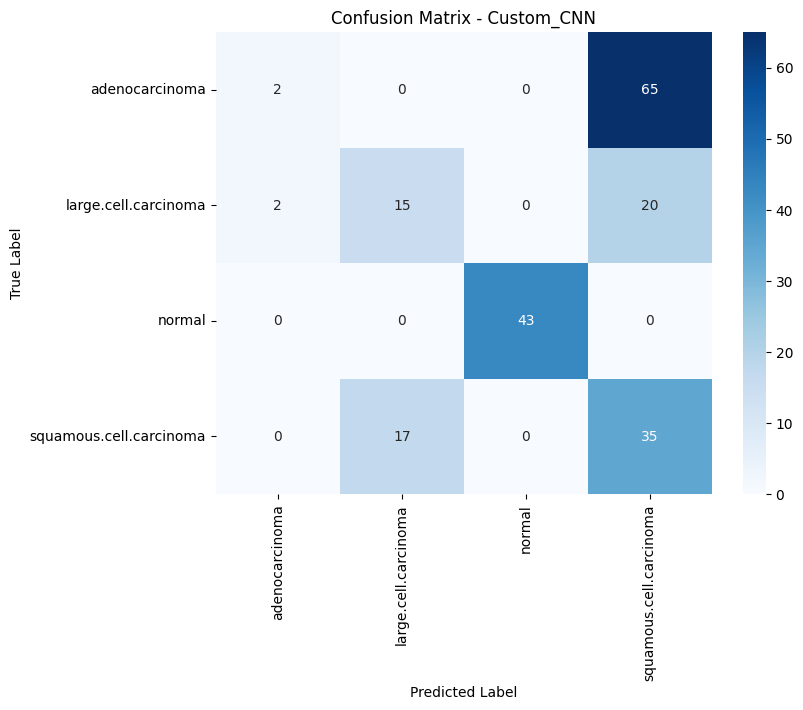

In [12]:
print("\n===== Training Custom CNN =====")
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

# Build the model
cnn_model = build_custom_cnn(input_shape, num_classes, learning_rate=CNN_LR)

# Get callbacks
cnn_callbacks = get_callbacks(CNN_MODEL_PATH, monitor='val_accuracy') # Monitor accuracy for CNN

# Train the model
print("\nStarting Custom CNN Training...")
history_cnn = cnn_model.fit(
    train_generator,
    epochs=CNN_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=cnn_callbacks,
    verbose=1 # Set to 1 or 2 for progress updates per epoch
)

# Plot history
plot_training_history(history_cnn, title_prefix="Custom CNN ")

# Load the best weights saved by ModelCheckpoint
print("\nLoading best weights for Custom CNN...")
cnn_model.load_weights(CNN_MODEL_PATH) # EarlyStopping already restored best weights, but this is safer

# Evaluate the best model
cnn_results = evaluate_model(cnn_model, validation_generator, classes)
all_model_results['CNN'] = cnn_results


===== Training MobileNetV2 =====

--- Phase 1: Initial Transfer Learning (Base Frozen) ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
MobileNetV2_Transfer Model Built and Compiled (Base Trainable: False).


Model: "MobileNetV2_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,092 (9.89 MB)

 Trainable params: 332,036 (1.27 MB)

 Non-trainable params: 2,261,056 (8.63 MB)


Starting MobileNetV2 Initial Training...
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.4386 - loss: 1.5505
Epoch 1: val_loss improved from inf to 1.10778, saving model to /content/drive/MyDrive/ctmodels/best_mobilenet_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 519ms/step - accuracy: 0.4399 - loss: 1.5464 - val_accuracy: 0.4774 - val_loss: 1.1078 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.6153 - loss: 1.0046
Epoch 2: val_loss improved from 1.10778 to 0.78990, saving model to /content/drive/MyDrive/ctmodels/best_mobilenet_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 274ms/step - accuracy: 0.6160 - loss: 1.0032 - val_accuracy: 0.6734 - val_loss: 0.7899 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.7415 - loss: 0.6746
Epoch 3: val_loss improved from 0.78990 to 0.58391, saving model to /content/drive/MyDrive/ctmodels/best_mobilenet_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/st

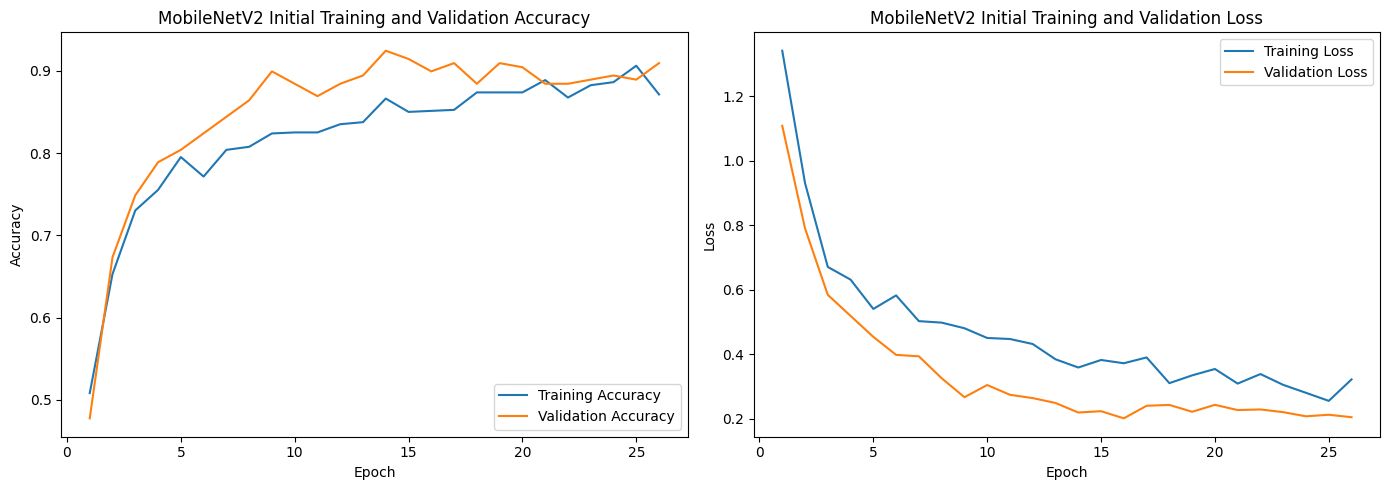


--- Phase 2: Fine-tuning (Unfreezing Base Model) ---
Loading best weights from initial phase...
Model re-compiled for fine-tuning.


Model: "MobileNetV2_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,092 (9.89 MB)

 Trainable params: 2,555,908 (9.75 MB)

 Non-trainable params: 37,184 (145.25 KB)


Starting MobileNetV2 Fine-tuning...
Epoch 27/56
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.5173 - loss: 1.6054
Epoch 27: val_loss improved from inf to 0.37001, saving model to /content/drive/MyDrive/ctmodels/best_mobilenet_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 85s 707ms/step - accuracy: 0.5167 - loss: 1.6071 - val_accuracy: 0.8744 - val_loss: 0.3700 - learning_rate: 1.0000e-05
Epoch 28/56
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.5376 - loss: 1.4255
Epoch 28: val_loss did not improve from 0.37001
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - accuracy: 0.5375 - loss: 1.4256 - val_accuracy: 0.7789 - val_loss: 0.5810 - learning_rate: 1.0000e-05
Epoch 29/56
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.5767 - loss: 1.1281
Epoch 29: val_loss did not improve from 0.37001
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 267ms/step - accuracy: 0.5770 - loss: 1.1288 - val_accuracy: 0.6231 - val_loss: 0.9675 - learning_rate: 1.0000e-05
Epoch 30/56
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 23

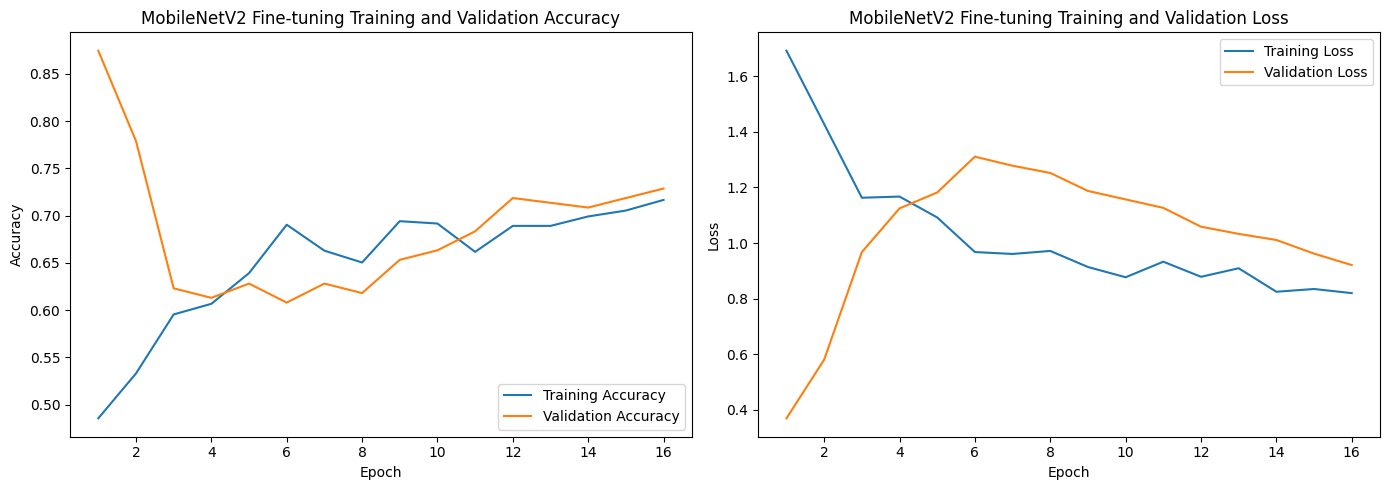


Loading best weights for MobileNetV2 after fine-tuning...

--- Evaluating Model: MobileNetV2_Transfer ---
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step

Validation Accuracy: 0.8744
Cohen's Kappa: 0.8308
Macro Avg ROC-AUC: 0.9846

Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.96      0.72      0.82        67
   large.cell.carcinoma       0.94      0.92      0.93        37
                 normal       1.00      0.93      0.96        43
squamous.cell.carcinoma       0.71      1.00      0.83        52

               accuracy                           0.87       199
              macro avg       0.90      0.89      0.89       199
           weighted avg       0.90      0.87      0.88       199



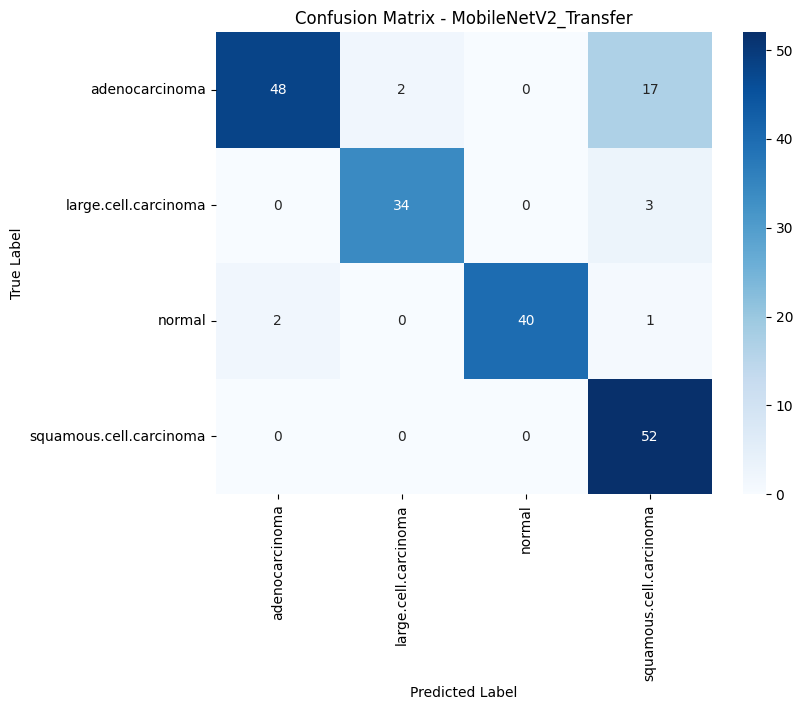

In [13]:
#  MobileNetV2 (Transfer Learning + Fine-tuning)

print("\n===== Training MobileNetV2 =====")
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

# --- Initial Transfer Learning Phase (Base Frozen) ---
print("\n--- Phase 1: Initial Transfer Learning (Base Frozen) ---")
mobilenet_base_model_fn = lambda **kwargs: MobileNetV2(include_top=False, weights='imagenet', input_shape=kwargs.get('input_shape'))

mobilenet_model = build_transfer_model(
    mobilenet_base_model_fn,
    input_shape,
    num_classes,
    trainable_base=False, # Keep base frozen initially
    learning_rate=INITIAL_LR,
    model_name="MobileNetV2_Transfer"
)

# Get callbacks for initial phase
mobilenet_callbacks_initial = get_callbacks(MOBILENET_MODEL_PATH, monitor='val_loss')

# Train the head
print("\nStarting MobileNetV2 Initial Training...")
history_mobilenet_initial = mobilenet_model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=mobilenet_callbacks_initial,
    verbose=1
)

# Plot initial history
plot_training_history(history_mobilenet_initial, title_prefix="MobileNetV2 Initial ")

# --- Fine-tuning Phase (Unfreeze Base) ---
print("\n--- Phase 2: Fine-tuning (Unfreezing Base Model) ---")

# Load the best weights from the initial phase
print("Loading best weights from initial phase...")
mobilenet_model.load_weights(MOBILENET_MODEL_PATH)

# Unfreeze the base model (or parts of it)
mobilenet_model.layers[1].trainable = True # The base model is typically the second layer after Input


# Re-compile the model with a lower learning rate for fine-tuning
mobilenet_model.compile(
    optimizer=Adam(learning_rate=FINETUNE_LR), # Use a very low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Model re-compiled for fine-tuning.")
mobilenet_model.summary() # Show summary with trainable params

# Get callbacks for fine-tuning phase (reuse checkpoint path to potentially overwrite if fine-tuning improves)
mobilenet_callbacks_finetune = get_callbacks(
    MOBILENET_MODEL_PATH,
    monitor='val_loss',
    early_stopping_patience=EARLY_STOPPING_PATIENCE + 5, # Allow a bit more patience for fine-tuning
    reduce_lr_patience=REDUCE_LR_PATIENCE
)

# Continue training (fine-tuning)
print("\nStarting MobileNetV2 Fine-tuning...")
# Determine initial epoch for history continuity if needed (optional)
initial_epoch_finetune = len(history_mobilenet_initial.history['loss'])

history_mobilenet_finetune = mobilenet_model.fit(
    train_generator,
    epochs=initial_epoch_finetune + FINETUNE_EPOCHS, # Total epochs
    initial_epoch=initial_epoch_finetune,        # Start from where initial training stopped
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=mobilenet_callbacks_finetune,
    verbose=1
)


plot_training_history(history_mobilenet_finetune, title_prefix="MobileNetV2 Fine-tuning ")


# Load the absolute best weights (potentially saved during fine-tuning)
print("\nLoading best weights for MobileNetV2 after fine-tuning...")
mobilenet_model.load_weights(MOBILENET_MODEL_PATH) # Best weights overall saved here

# Evaluate the final fine-tuned model
mobilenet_results = evaluate_model(mobilenet_model, validation_generator, classes)
all_model_results['MobileNetV2'] = mobilenet_results


===== Training ResNet50 =====

--- Phase 1: Initial Transfer Learning (Base Frozen) ---
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ResNet50_Transfer Model Built and Compiled (Base Trainable: False).


Model: "ResNet50_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,122,500 (92.02 MB)

 Trainable params: 530,180 (2.02 MB)

 Non-trainable params: 23,592,320 (90.00 MB)


Starting ResNet50 Initial Training...
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.4364 - loss: 1.6453
Epoch 1: val_loss improved from inf to 1.73715, saving model to /content/drive/MyDrive/ctmodels/best_resnet_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 36s 471ms/step - accuracy: 0.4373 - loss: 1.6407 - val_accuracy: 0.3367 - val_loss: 1.7371 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.5250 - loss: 1.1719
Epoch 2: val_loss improved from 1.73715 to 1.28720, saving model to /content/drive/MyDrive/ctmodels/best_resnet_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 285ms/step - accuracy: 0.5249 - loss: 1.1723 - val_accuracy: 0.3367 - val_loss: 1.2872 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.4898 - loss: 1.1868
Epoch 3: val_loss improved from 1.28720 to 1.11769, saving model to /content/drive/MyDrive/ctmodels/best_resnet_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 299ms/step - accurac

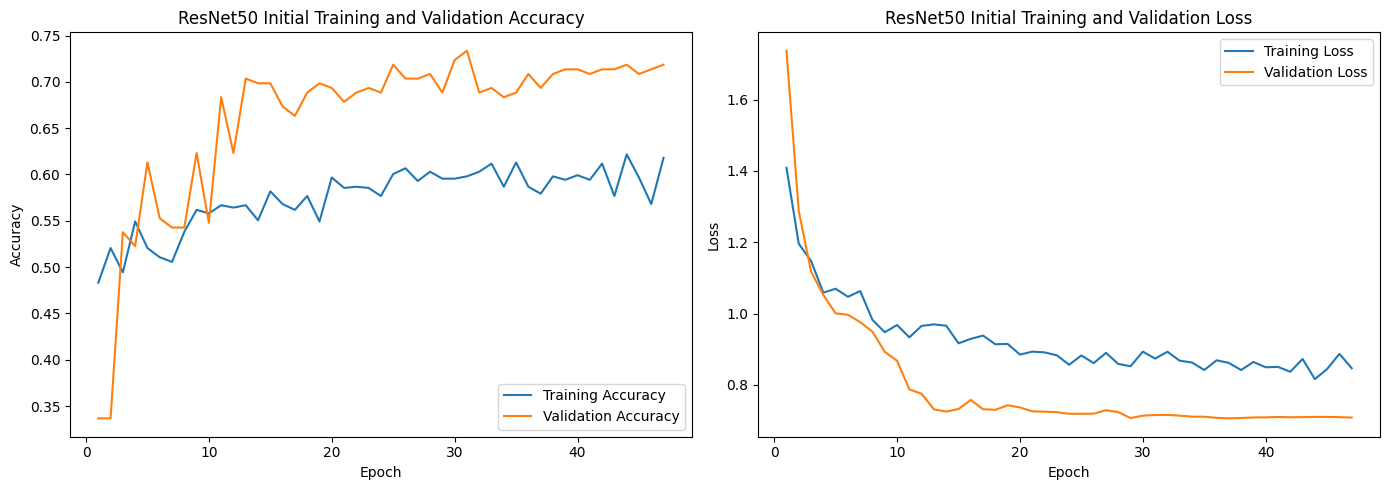


--- Phase 2: Fine-tuning (Unfreezing Base Model) ---
Loading best weights from initial phase...
Model re-compiled for fine-tuning.


Model: "ResNet50_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,122,500 (92.02 MB)

 Trainable params: 24,064,772 (91.80 MB)

 Non-trainable params: 57,728 (225.50 KB)


Starting ResNet50 Fine-tuning...
Epoch 48/77
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.3307 - loss: 2.1760
Epoch 48: val_loss improved from inf to 2.48659, saving model to /content/drive/MyDrive/ctmodels/best_resnet_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 95s 785ms/step - accuracy: 0.3319 - loss: 2.1693 - val_accuracy: 0.2261 - val_loss: 2.4866 - learning_rate: 1.0000e-05
Epoch 49/77
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.4958 - loss: 1.3264
Epoch 49: val_loss improved from 2.48659 to 2.38379, saving model to /content/drive/MyDrive/ctmodels/best_resnet_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 436ms/step - accuracy: 0.4960 - loss: 1.3265 - val_accuracy: 0.2362 - val_loss: 2.3838 - learning_rate: 1.0000e-05
Epoch 50/77
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.5409 - loss: 1.2349
Epoch 50: val_loss improved from 2.38379 to 1.64727, saving model to /content/drive/MyDrive/ctmodels/best_resnet_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 420ms/step 

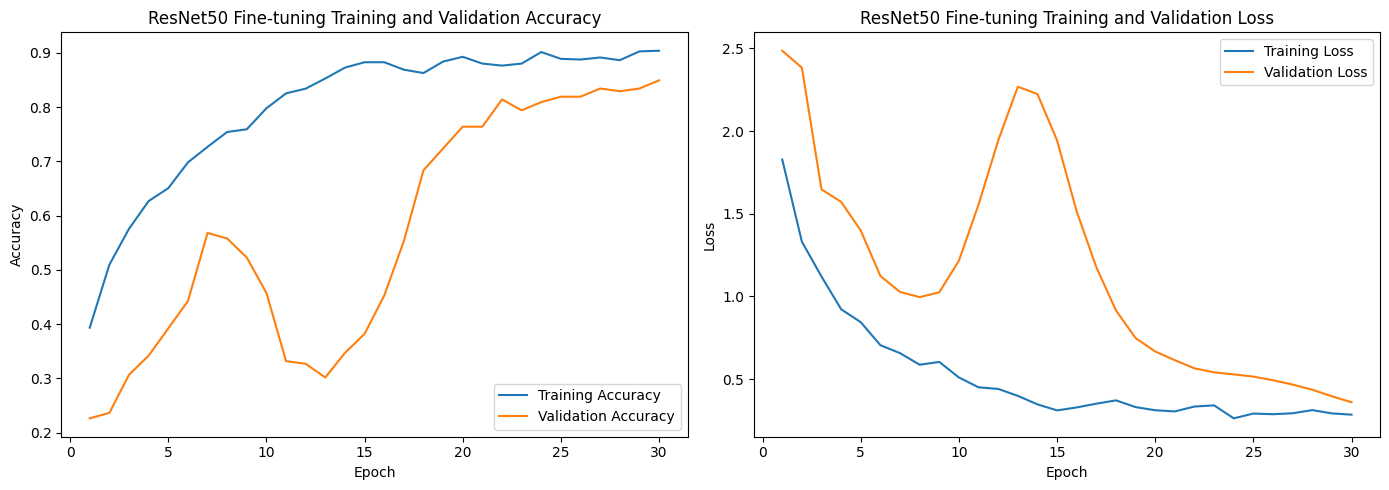


Loading best weights for ResNet50 after fine-tuning...

--- Evaluating Model: ResNet50_Transfer ---
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 385ms/step

Validation Accuracy: 0.8492
Cohen's Kappa: 0.7974
Macro Avg ROC-AUC: 0.9769

Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.86      0.73      0.79        67
   large.cell.carcinoma       0.73      0.89      0.80        37
                 normal       0.98      1.00      0.99        43
squamous.cell.carcinoma       0.83      0.85      0.84        52

               accuracy                           0.85       199
              macro avg       0.85      0.87      0.86       199
           weighted avg       0.85      0.85      0.85       199



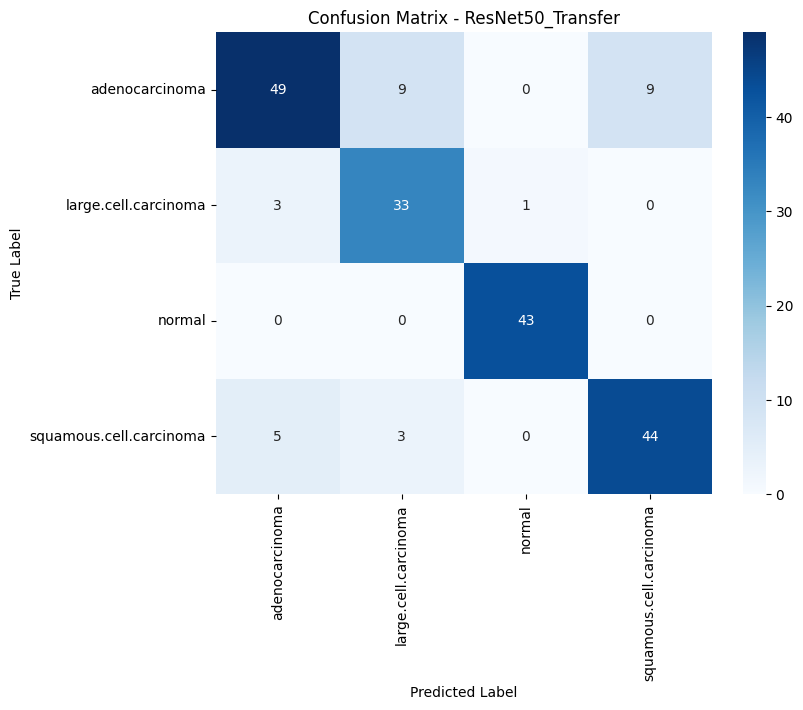

In [14]:
# ResNet50 (Transfer Learning + Fine-tuning)


print("\n===== Training ResNet50 =====")
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

# --- Initial Transfer Learning Phase (Base Frozen) ---
print("\n--- Phase 1: Initial Transfer Learning (Base Frozen) ---")
resnet_base_model_fn = lambda **kwargs: ResNet50(include_top=False, weights='imagenet', input_shape=kwargs.get('input_shape'))

resnet_model = build_transfer_model(
    resnet_base_model_fn,
    input_shape,
    num_classes,
    trainable_base=False,
    learning_rate=INITIAL_LR,
    model_name="ResNet50_Transfer"
)

# Get callbacks
resnet_callbacks_initial = get_callbacks(RESNET_MODEL_PATH, monitor='val_loss')

# Train the head
print("\nStarting ResNet50 Initial Training...")
history_resnet_initial = resnet_model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=resnet_callbacks_initial,
    verbose=1
)

# Plot initial history
plot_training_history(history_resnet_initial, title_prefix="ResNet50 Initial ")


# --- Fine-tuning Phase (Unfreeze Base) ---
print("\n--- Phase 2: Fine-tuning (Unfreezing Base Model) ---")

# Load the best weights from the initial phase
print("Loading best weights from initial phase...")
resnet_model.load_weights(RESNET_MODEL_PATH)

# Unfreeze the base model
resnet_model.layers[1].trainable = True # Base model



# Re-compile the model with a lower learning rate
resnet_model.compile(
    optimizer=Adam(learning_rate=FINETUNE_LR), # Low LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Model re-compiled for fine-tuning.")
resnet_model.summary()

# Get callbacks for fine-tuning phase
resnet_callbacks_finetune = get_callbacks(
    RESNET_MODEL_PATH,
    monitor='val_loss',
    early_stopping_patience=EARLY_STOPPING_PATIENCE + 5,
    reduce_lr_patience=REDUCE_LR_PATIENCE
)

# Continue training (fine-tuning)
print("\nStarting ResNet50 Fine-tuning...")
initial_epoch_finetune_resnet = len(history_resnet_initial.history['loss'])

history_resnet_finetune = resnet_model.fit(
    train_generator,
    epochs=initial_epoch_finetune_resnet + FINETUNE_EPOCHS,
    initial_epoch=initial_epoch_finetune_resnet,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=resnet_callbacks_finetune,
    verbose=1
)

# Plot fine-tuning history
plot_training_history(history_resnet_finetune, title_prefix="ResNet50 Fine-tuning ")

# Load the absolute best weights
print("\nLoading best weights for ResNet50 after fine-tuning...")
resnet_model.load_weights(RESNET_MODEL_PATH)

# Evaluate the final fine-tuned model
resnet_results = evaluate_model(resnet_model, validation_generator, classes)
all_model_results['ResNet50'] = resnet_results



===== Model Comparison =====

--- Performance Metrics Summary ---
             Accuracy   Kappa  ROC-AUC (Macro)  Macro Avg F1  Weighted Avg F1
Model                                                                        
CNN            0.4774  0.3115           0.8011        0.4745           0.4222
MobileNetV2    0.8744  0.8308           0.9846        0.8870           0.8751
ResNet50       0.8492  0.7974           0.9769        0.8555           0.8483


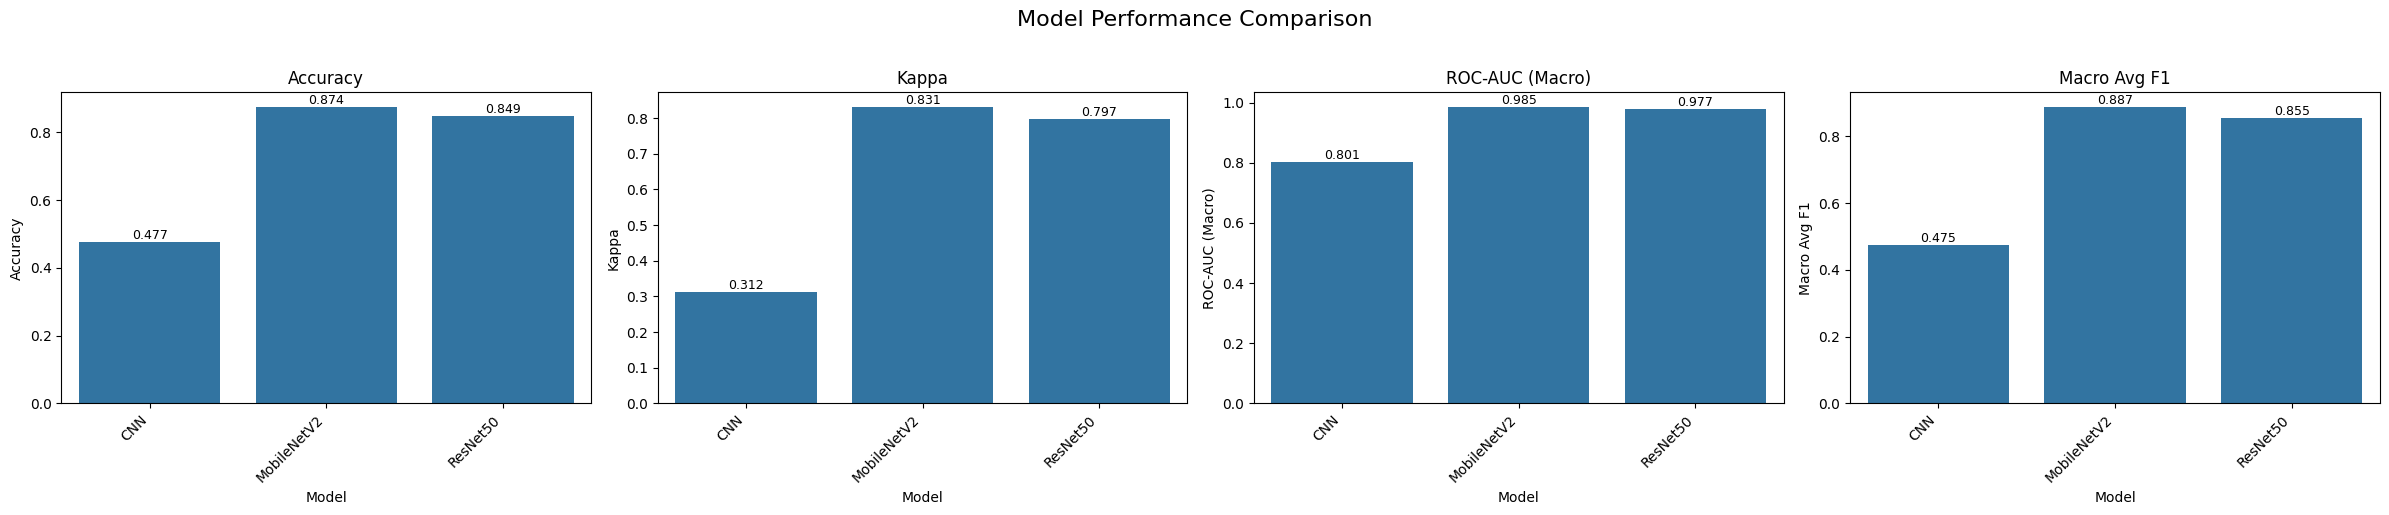

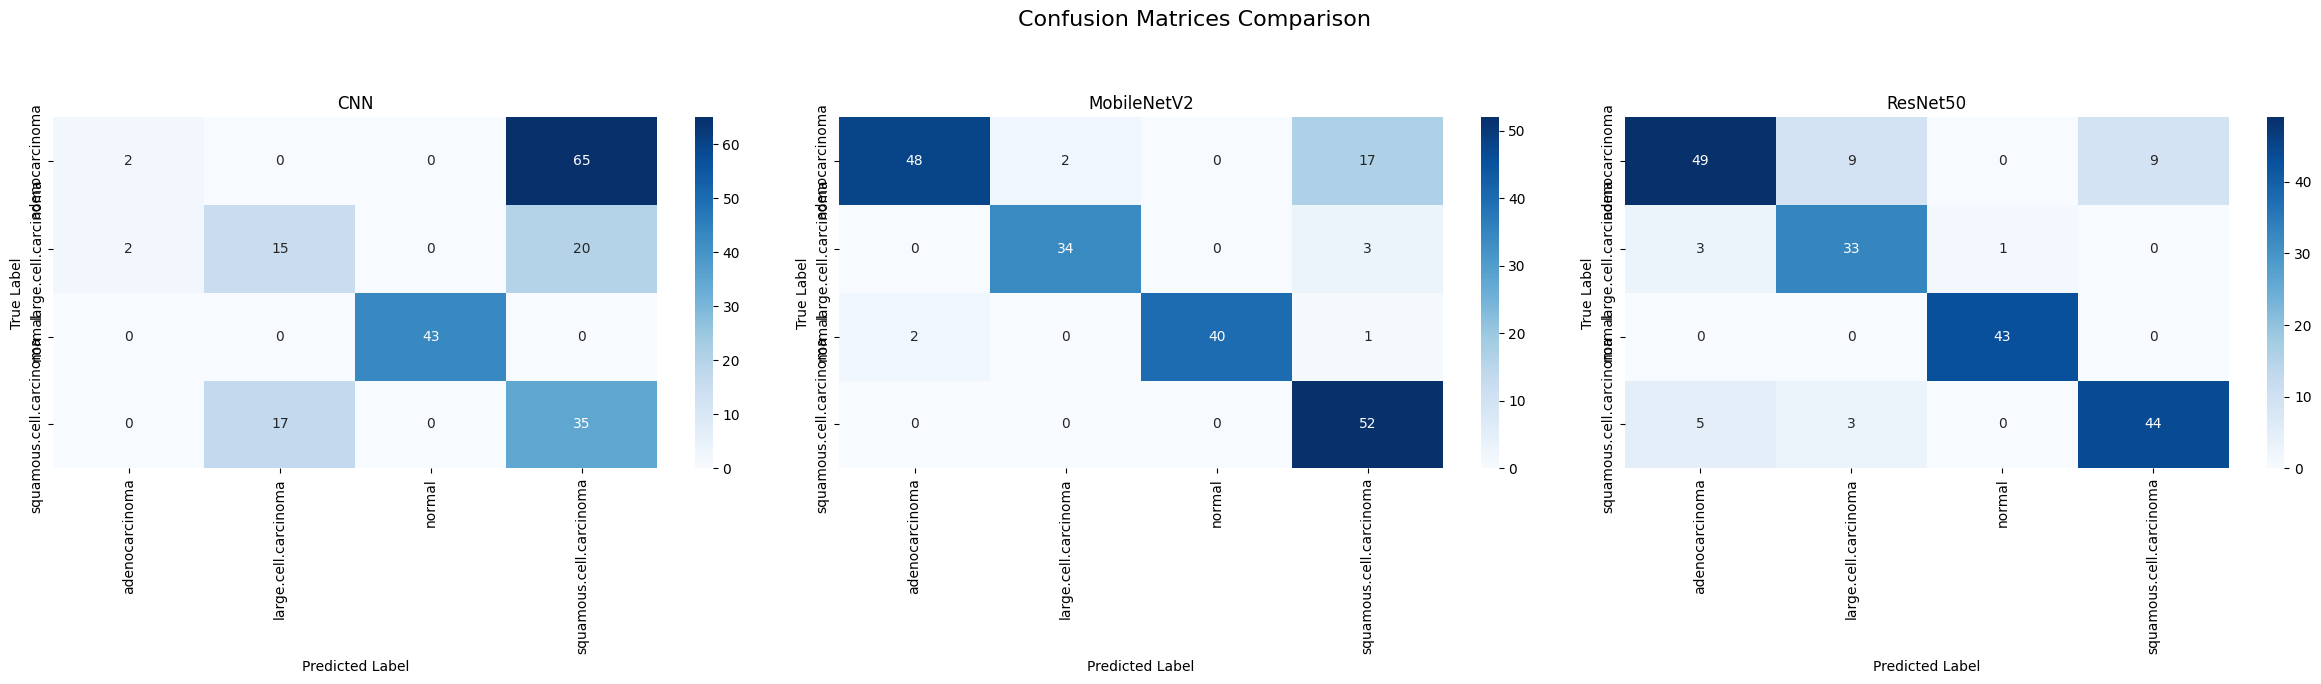


--- Detailed Classification Reports ---

--- CNN ---
                         precision    recall  f1-score   support

         adenocarcinoma       0.50      0.03      0.06        67
   large.cell.carcinoma       0.47      0.41      0.43        37
                 normal       1.00      1.00      1.00        43
squamous.cell.carcinoma       0.29      0.67      0.41        52

               accuracy                           0.48       199
              macro avg       0.57      0.53      0.47       199
           weighted avg       0.55      0.48      0.42       199


--- MobileNetV2 ---
                         precision    recall  f1-score   support

         adenocarcinoma       0.96      0.72      0.82        67
   large.cell.carcinoma       0.94      0.92      0.93        37
                 normal       1.00      0.93      0.96        43
squamous.cell.carcinoma       0.71      1.00      0.83        52

               accuracy                           0.87       199
          

In [15]:
print("\n===== Model Comparison =====")

# --- Tabular Summary ---
comparison_data = []
for model_name, results in all_model_results.items():
    report = results['classification_report_dict']
    comparison_data.append({
        'Model': model_name,
        'Accuracy': results['accuracy'],
        'Kappa': results['kappa'],
        'ROC-AUC (Macro)': results['roc_auc'],
        'Macro Avg F1': report['macro avg']['f1-score'],
        'Weighted Avg F1': report['weighted avg']['f1-score']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Model')
print("\n--- Performance Metrics Summary ---")
print(comparison_df.round(4))

# --- Bar Plots for Key Metrics ---
metrics_to_plot = ['Accuracy', 'Kappa', 'ROC-AUC (Macro)', 'Macro Avg F1']
n_metrics = len(metrics_to_plot)
plt.figure(figsize=(6 * n_metrics, 5))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(1, n_metrics, i + 1)
    sns.barplot(x=comparison_df.index, y=comparison_df[metric])
    plt.title(metric)
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    # Add value labels to bars
    for index, value in enumerate(comparison_df[metric]):
        plt.text(index, value, f'{value:.3f}', ha='center', va='bottom', fontsize=9)


plt.suptitle("Model Performance Comparison", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


# --- Plot Confusion Matrices Side-by-Side ---
n_models = len(all_model_results)
plt.figure(figsize=(8 * n_models, 7)) # Adjusted figsize
plt.suptitle("Confusion Matrices Comparison", fontsize=16, y=1.0) # Adjusted y position

for i, (model_name, results) in enumerate(all_model_results.items()):
    plt.subplot(1, n_models, i + 1)
    sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f"{model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
plt.show()

# --- Detailed Classification Reports ---
print("\n--- Detailed Classification Reports ---")
for model_name, results in all_model_results.items():
    print(f"\n--- {model_name} ---")
    print(results['classification_report_str'])